Tasks:  
Load and Clean Data: Import the text, convert it to lowercase, remove punctuation and stop words (using nltk).  
Tokenize and Analyze: Split the text into words and calculate word frequencies.  
Visualize Results:  
Create a bar chart of the top 10 most frequent words.  
Optionally, generate a word cloud.

In [2]:
# Import scraping libraries
# requests - sends HTTP requests to webpages, fetches content
# BeautifulSoup - parses the content of a webpage

In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import nltk.tokenize.punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize

In [3]:
os.chdir("/Users/sunny/Library/CloudStorage/OneDrive-Personal/Documents/Python/NLP")

In [5]:
pwd

'/Users/sunny/Library/CloudStorage/OneDrive-Personal/Documents/Python/NLP'

In [7]:
# Let's start by scraping BBC Science articles
# Maybe investigate frequency of AI/ML?
# ...oops. BBC Science uses javacript to load its sub-pages, which means you need Selenium
# Instead, let's use a static HTML site - like the Guardian
# We know it's static because page numbers appear in the URL

In [9]:
# Step 1: Define the base URL and headers
base_url = "https://www.theguardian.com/lifeandstyle/relationships"
headers = {"User-Agent": "Mozilla/5.0"}  # Prevent blocking by identifying as a browser

# Step 2: Loop through multiple pages
all_articles = []
for page in range(1, 100):  # Adjust the range for the number of pages you want to scrape
    url = f"{base_url}?page={page}"  # Construct the paginated URL
    response = requests.get(url, headers=headers)

    if response.status_code == 200:  # Check if the request was successful
        soup = BeautifulSoup(response.text, 'html.parser')

        # Step 3: Extract article links and titles
        articles = soup.find_all('a', class_='dcr-ezvrjj')  # Update with correct class
        for article in articles:
            title = article.get('aria-label', 'No title found')
            link = "https://www.theguardian.com" + article['href']  # The Guardian uses absolute URLs
            all_articles.append((title, link))
    else:
        print(f"Failed to fetch page {page}. Status code: {response.status_code}")
        break

KeyboardInterrupt: 

In [ ]:
# Step 4: Verify that article titles and links are correct
for idx, (title, link) in enumerate(all_articles, start=1):
    if idx<10:
        print(f"{idx}. {title}\n   {link}")

In [25]:
# Define function to scrape article text including drop capitals
def get_article_text_with_links_2(soup):
    # Create an empty string to store the text
    article_text = ''
    
    # Loop through all paragraphs
    for p in soup.find_all('p', class_=['dcr-15rw6c2', 'dcr-s3ycb2']):
        # Check if there's a <span> with the drop capital class within the paragraph
        drop_capital_span = p.find('span', class_='dcr-15rw6c2')
        
        if drop_capital_span:
            drop_capital_text = drop_capital_span.get_text(strip=True)
            
            # Check if the drop capital is followed by text in the same paragraph
            rest_of_paragraph = ''.join(
                child if isinstance(child, str) else child.get_text()
                for child in p.children
                if child != drop_capital_span
            )
            
            if rest_of_paragraph and not rest_of_paragraph[0].isspace():
                # If there's no space between the drop cap and the next text, concatenate them
                article_text += drop_capital_text + rest_of_paragraph[0]
                rest_of_paragraph = rest_of_paragraph[1:]  # Remove the first character, as it's already added
            else:
                # Otherwise, just add the drop capital with a space
                article_text += drop_capital_text + ' '
            
            # Add the remaining text from the paragraph
            article_text += rest_of_paragraph + ' '
        else:
            # Handle paragraphs without a drop cap
            for element in p.children:
                if isinstance(element, str):  # If the element is just text, add it
                    article_text += element.strip() + ' '
                elif element.name == 'a':  # If the element is a hyperlink
                    article_text += element.get_text(strip=True) + ' '
    
    # Clean up spaces before punctuation: remove space before punctuation marks, remove trailing space
    article_text = re.sub(r'\s([?.!,¿])', r'\1', article_text).strip()

    # Convert non-breaking spaces to regular spaces
    article_text = article_text.replace('\xa0', ' ')
    
    return article_text

In [55]:
# Now use the function to extract text from the article
articles_data = []

for idx, (title, link) in enumerate(all_articles, start=1):
    #if idx<100:
        #print(link)
        article_response = requests.get(link, headers=headers)
        
        if article_response.status_code == 200:
            article_soup = BeautifulSoup(article_response.text, 'html.parser')
            
            # Extract text
            article_text = get_article_text_with_links_2(article_soup)

            # Extract date; it appears in two tags/classes 
            date_element = article_soup.find('span', class_ = "dcr-u0h1qy")
            if not date_element:
                date_element = article_soup.find('div', class_='dcr-1pexjb9')
            date_text = date_element.get_text(strip=True).rsplit(" ", 1)[0] if date_element else None
            parsed_date = datetime.strptime(date_text, "%a %d %b %Y %H.%M") if date_text else None
            
            # Add to articles data
            articles_data.append({'title': title, 'link': link, 'date': parsed_date, 'text': article_text})
        
        else:
            # If the request fails, print an error message
            print(f"Failed to fetch article {idx}. Status code: {article_response.status_code}")

# Convert to DataFrame
guardian_relationships = pd.DataFrame(articles_data)

In [56]:
guardian_relationships.to_csv("guardian_relationships_articles.csv", index=False)

In [14]:
guardian_relationships[guardian_relationships['date'].isna()][['title', 'link']]

,title,link
296,Old Lesbians: reclaiming old age and queerness...,https://www.theguardian.com/world/ng-interacti...
781,Lover to lover: photographers’ most intimate i...,https://www.theguardian.com/artanddesign/galle...
1813,Heads together: the light of hopeful faces – i...,https://www.theguardian.com/books/gallery/2021...
1872,From Bob and Blanche to Kath and Kim: Australi...,https://www.theguardian.com/artanddesign/galle...
1919,An uncertain future for Japan’s love hotels – ...,https://www.theguardian.com/artanddesign/galle...


**On to some NLP analysis**

In [12]:
guardian_relationships = pd.read_csv("guardian_relationships_articles.csv")

In [18]:
# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/sunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/sunny/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [69]:
# Combine all articles into a single string
all_text = " ".join(guardian_relationships['text'].tolist())

# Set up stop words
stop_words = set(stopwords.words('english'))

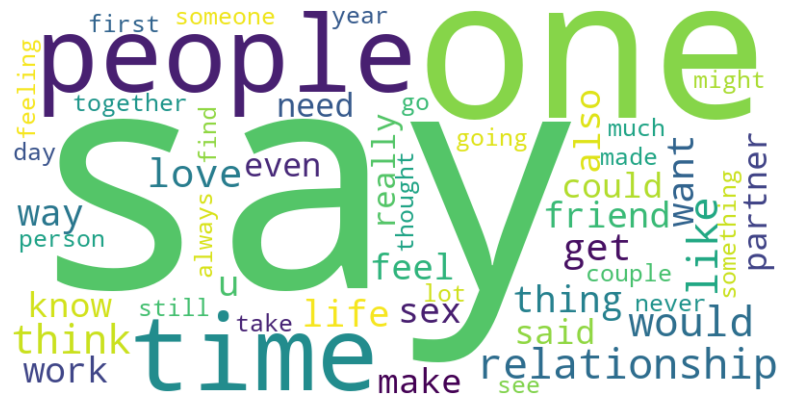

In [87]:
# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=stop_words,
    max_words=50,  # Limit to the top 100 words
    colormap='viridis'  # Change colormap if desired
).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axes
plt.show()

In [89]:
# Try and see if wordclouds have changed

In [91]:
# Topic modelling

In [32]:
guardian_relationships[guardian_relationships['text'].isna()].count()

title             27
link              27
date              22
text               0
processed_text     0
dtype: int64

In [39]:
# Preprocess the text
def preprocess(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Keep alphabetic tokens only
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stop words
    return " ".join(tokens)

# Apply preprocessing to all article text
guardian_relationships_no_na = guardian_relationships[guardian_relationships['text'].notna()].copy()
guardian_relationships_no_na['processed_text'] = guardian_relationships_no_na['text'].apply(preprocess)

# Convert text to a document-term matrix
vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Limit to 1000 features
dtm = vectorizer.fit_transform(guardian_relationships_no_na['processed_text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # Set 5 topics
lda.fit(dtm)

# Display topics
for i, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-5:]]  # Top 10 words
    print(f"Topic {i+1}: {', '.join(top_words)}")


Topic 1: think, people, feel, like, sex
Topic 2: time, dating, like, love, people
Topic 3: family, like, really, time, says
